This is the repository for the "", a Google Summer of Code 2023 project by ML4Sci instution QMLHeP group. The purpose of the project is to have a proof-of-concept Quantum Vision Transformer implementation for the jet data classification.

It is not possible to implement a QViT using this code yet as the project is still in progress. However this repo will be updated weekly to show the progress.

Papers of interest

Conference Paper: https://indico.jlab.org/event/459/contributions/11832/ \
Beamsplitter Decomposition Paper: https://arxiv.org/pdf/2212.07389.pdf \
Beamsplitter Qumode Explanation: https://quantumcomputing.stackexchange.com/questions/32286/how-to-represent-beam-splitter-and-kerr-gates-as-basic-quantum-logic-gates\ \
QViT Paper: https://arxiv.org/pdf/2209.08167.pdf \

The first method to achieve our goal will be reproducing the architecture in  https://arxiv.org/pdf/2209.08167.pdf (referred as QViT paper in the file) if possible.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import seaborn as sns
import math
from tqdm.notebook import tqdm
from QViT import *

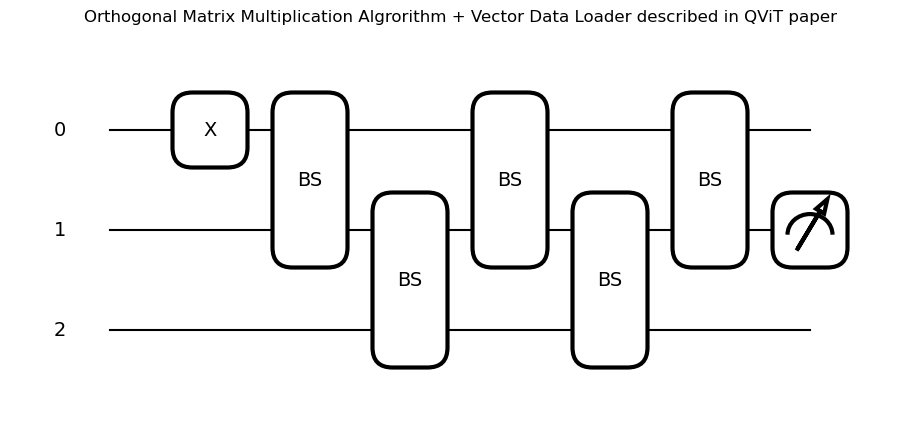

In [2]:
length = 3
qml.draw_mpl(mmult_bs,show_all_wires=True,wire_order=[i for i in range(length)])(torch.zeros(10),torch.ones(2))
q=plt.title('Orthogonal Matrix Multiplication Algrorithm + Vector Data Loader described in QViT paper')

Text(0.5, 1.0, 'BeamSplitter Equivalent Structure')

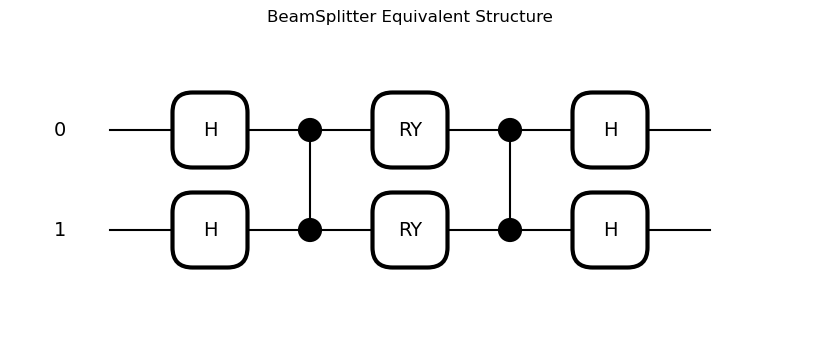

In [3]:
qml.draw_mpl(rbs,show_all_wires=True)([0,1],torch.tensor([0]))
plt.title('BeamSplitter Equivalent Structure')

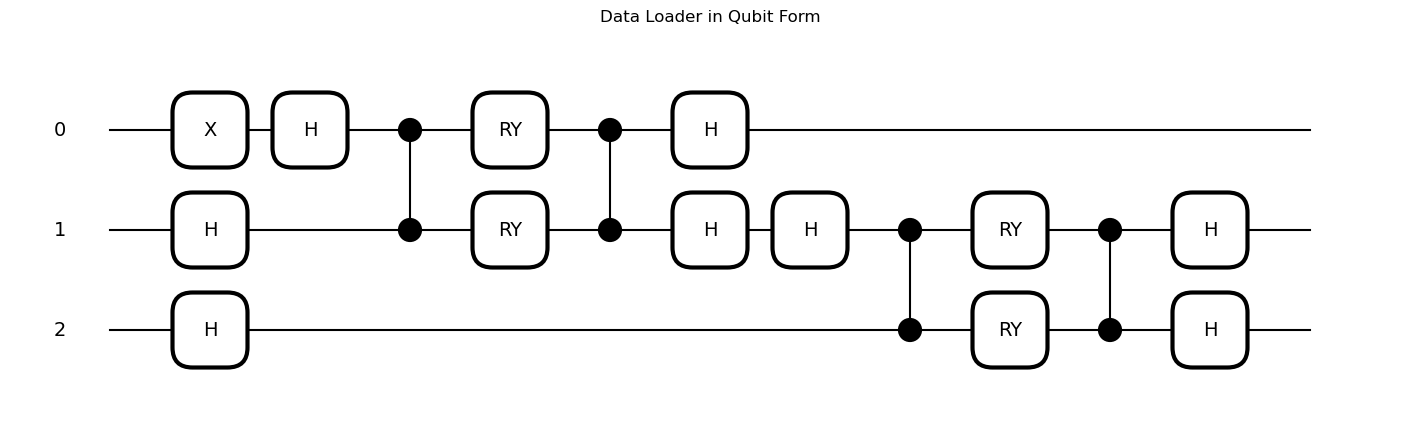

In [4]:
qml.draw_mpl(vector_loader,show_all_wires=True,wire_order=[i for i in range(3)])(torch.ones(2))
q=plt.title('Data Loader in Qubit Form')

Suggested data loader takes n-1 parameters to load length n data.
Data loader circuit can be expressed as the following.

$$\Psi = \left[\Sigma_{i=0}^{n-2} \left(\Pi^{i-1}_{j=0}\sin \alpha_j \right)e_i \cos \alpha_i \right]+\left(\Pi^{n-1}_{j=0}\sin \alpha_j \right)e_{n-1}$$.
Therefore, one can load normalized vector $x_i$ using the following parameters:
$$\alpha_0 = cos^{-1}(x_0)$$
$$\alpha_i = cos^{-1}\left(x_i / \left[1-\Sigma_{j=0}^{i-1}x_j^2\right]^{-1/2}\right)$$


In [5]:
mmult?

Signature: mmult(phi, alphas, wires=None)
Docstring: <no docstring>
File:      ~/OneDrive/SoC/Transformer/QViTHEP/QViT/Circuits.py
Type:      function


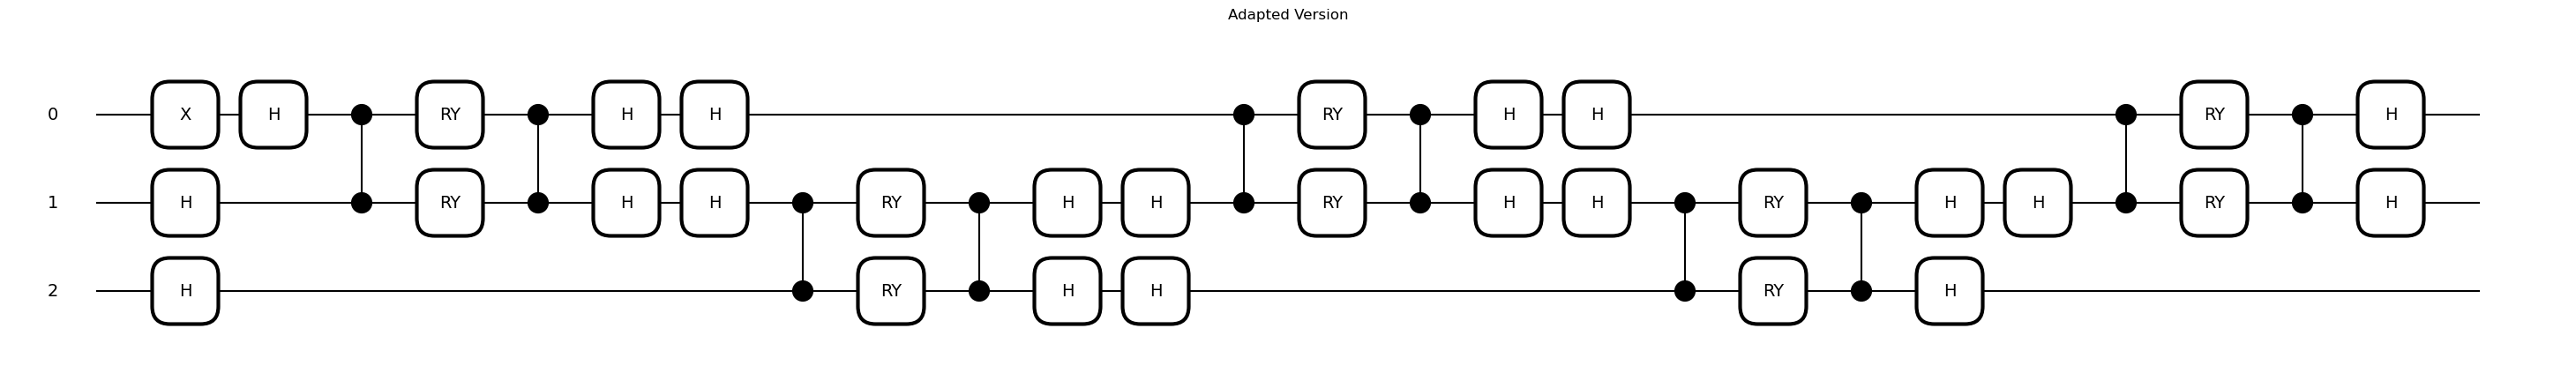

In [6]:
qml.draw_mpl(mmult,show_all_wires=True,wire_order=[i for i in range(length)])(torch.zeros(10),torch.zeros(2))
q=plt.title('Adapted Version')

# Vector Loader Demonstration

In [7]:
X = torch.tensor([1/2,1/2,1/np.sqrt(2)],requires_grad=False)
alphas = convert_array(X)
wires = [ str(i) for i in range (X.shape[0])]

Loading X: [0.5        0.5        0.70710678]


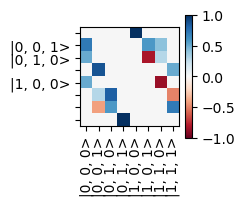

In [8]:
plot_opm(vector_loader,[alphas,wires],wire_order = None)
print('Loading X: {}'.format(X.numpy()))

# Matrix Loader Demonstration

In [9]:
X = torch.tensor([[1,1,1],[0,1,0],[0,0,1]],requires_grad=False)
nrow,ncolumn = X.shape
mag_wires = [ '||X||_'+str(i) for i in range (nrow)]
wires = [ str(i) for i in range (ncolumn)]

mag_alphas,alphas = convert_matrix(X)

Text(0.5, 1.0, "Matrix Loader's Matrix Representation for Loading X")

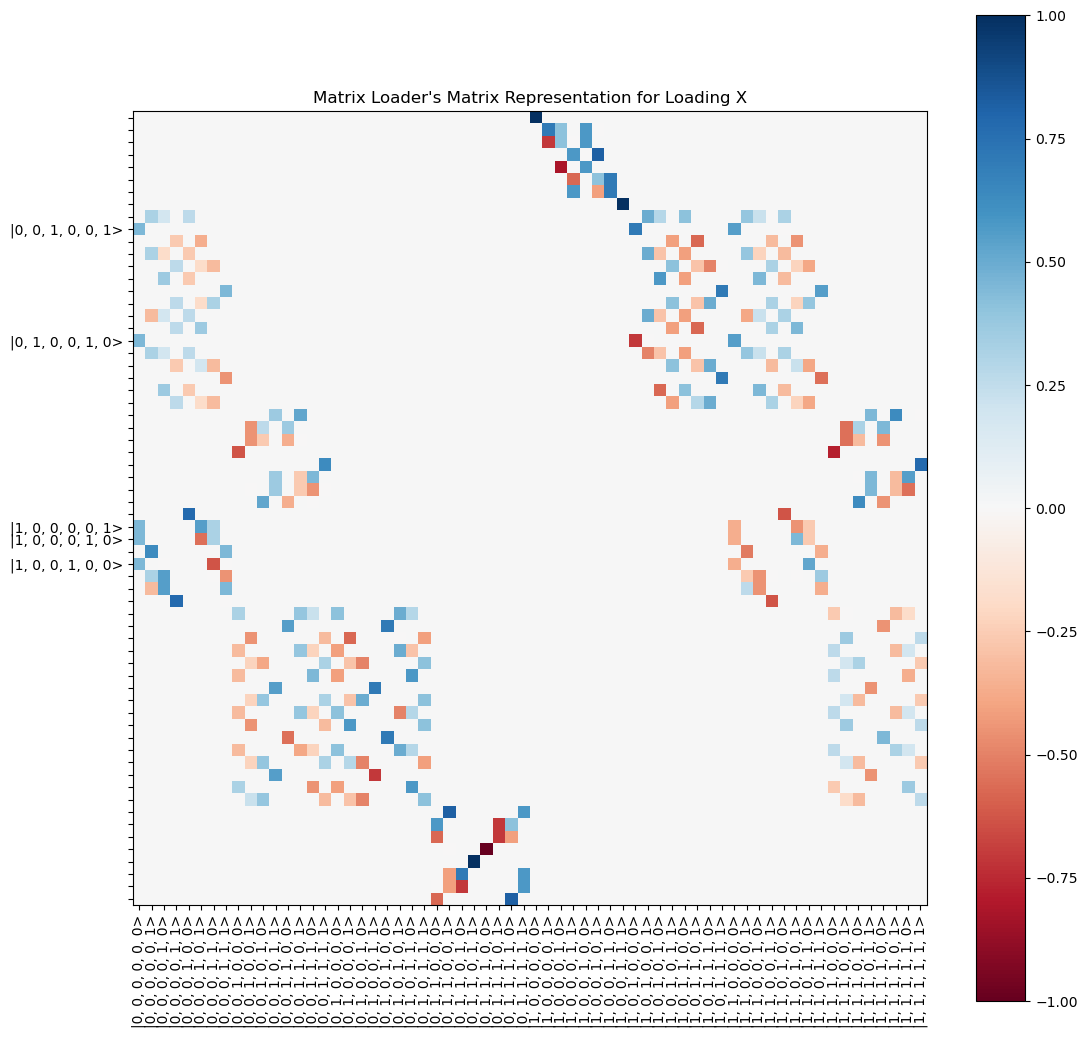

In [10]:
plot_opm(matrix_loader,(mag_alphas,alphas,mag_wires,wires),wire_order = mag_wires+wires)
plt.title('Matrix Loader\'s Matrix Representation for Loading X')

# Matrix Multiplication on X Demonstration

Soon to be Added

# Future Goal's

Goal's Achieved from 25/05 to 07/06:

Implementing Beam splitter equivalent for a Qubit circuit.\
How to parametrize data for the circuit\
Loading a vector\
Applying a matrix multiplication on a loaded vector.\
Training the mentioned matrix.

Goal's Achieved from 07/06 to 14/06:\
-Loading a matrix 

Future Goals\
-Find a method to retrieve the sign of the matrix elements.\
-\
-Construct a single head transformer of few layers.\
-Look for alternative ways for a QViT\

In [11]:
dev = qml.device('default.qubit', wires=2, shots=1000)
@qml.qnode(dev,interface='torch')
def RBS(wires,th):
    
    qml.Hadamard(wires[0])
    qml.Hadamard(wires[1])
    qml.CZ(wires)
    qml.RY( th,wires[0])
    qml.RY(-th,wires[1])
    qml.CZ(wires)
    qml.Hadamard(wires[0])
    qml.Hadamard(wires[1])
    return qml.state()

In [ ]:
plt.imshow(qml.matrix(RBS)([0,1],np.pi/2).real)
plt.colorbar()